# Video Super Resolution

## By Daniel Shkreli and Victor Reyes

### Import what we need

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import lpips
import torchvision
from torchvision.datasets.video_utils import VideoClips
from torchvision import datasets, models, transforms
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import matplotlib.pyplot as plt
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    
print(torch.__version__)
print(torchvision.__version__)

Using the GPU!
1.4.0
0.5.0


### Import the dataset
To do this, we will be downloading the videos of the National Geographic channel.

### Create the model
We will use resnet 18, pretrained at first.
from https://github.com/hsinyilin19/ResNetVAE


In [2]:
input_size = 256
data_transforms = {
    'train_in': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train_in_no_normalize': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),

        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train_target': transforms.Compose([
        transforms.Resize(input_size*2),
        transforms.CenterCrop(input_size*2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
def initialize_resnet_model(resume_from = None):
    resnet = models.resnet18(pretrained=True)
    out_size = resnet.fc.in_features
    print("out_size:", out_size)
    layers = []
    for child in resnet.children():
        for param in child.parameters():
            param.requires_grad = True
        layers.append(child)
    resnet = nn.Sequential(*layers[:-1])
    
    #resnet.fc =  # create latent
    
    #resnet.add_module("bottleneck", nn.Sequential()
    if resume_from is not None:
        print(f"Loading weights from {resume_from}")
        model.load_state_dict(torch.load(resume_from))
    return resnet, out_size

def initialize_bottleneck(input_size, latent_size=1024):
    bottleneck = nn.Sequential(nn.Linear(input_size, latent_size),
                               nn.BatchNorm1d(latent_size, momentum=0.01))
    return bottleneck

def initialize_decoder():
    stride = (2,2)
    padding = (1,1)
    convTrans6 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=(4,4), stride=(1,1),
                           padding=(0,0)),
        nn.BatchNorm2d(1024, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans7 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(512, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans8 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(256, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans9 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(128, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans10 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(64, momentum=0.01),
        nn.ReLU(inplace=True),
    )
   
    convTrans11 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(64, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans12 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(32, momentum=0.01),
        nn.ReLU(inplace=True),
    )
    
    convTrans13 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=(4,4), stride=stride,
                           padding=padding),
        nn.BatchNorm2d(3, momentum=0.01),
        nn.Sigmoid(),
    )
    return nn.Sequential(convTrans6,
                         convTrans7,
                         convTrans8,
                         convTrans9,
                         convTrans10,
                         convTrans11,
                         convTrans12,
                         convTrans13) 

    




def get_dataloaders(batch_size, input_size = 256, shuffle = True):
    
    train_dataset = datasets.ImageFolder(root="yt-dls/train/", transform = data_transforms['train_target'])
    val_dataset = datasets.ImageFolder(root="yt-dls/val/",  transform = data_transforms['train_target'])
    test_dataset = datasets.ImageFolder(root="yt-dls/test/",  transform = data_transforms['train_target'])

    dataloaders_dict = {'train': torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
                       'val': torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True),
                       'test': torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)}
    return dataloaders_dict

In [3]:
#dl = get_dataloaders(5)
#print(dl['train'])
#video_folders = os.listdir("yt-dls/train/0")
#np.random.permutation(video_folders)

In [4]:
def make_optimizer(resnet, bottleneck, decoder):
    # Get all the parameters
    print("bottleneck params", bottleneck.parameters())
    print("decoder params", decoder.parameters())
    params_to_update = list(resnet.parameters()) + list(bottleneck.parameters()) + list(decoder.parameters())
    print("Params to learn:")
    for name, param in resnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    for name, param in bottleneck.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    for name, param in decoder.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    # Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    #optimizer = optim.Adagrad(params_to_update, lr=0.001)
    return optimizer

In [5]:
def fit_one_point(resnet, bottleneck, decoder, point, in_transforms, target_transforms, iterations=1000):
    batched_input_1 = []
    batched_input_2 = []
    batched_targets = []
    for example in point:  
        in_1 = in_transforms(example[0].permute(2,0,1)) # frame_i-1
        in_2 = in_transforms(example[1].permute(2,0,1)) # frame_i
        target = target_transforms(example[1].permute(2,0,1))
        batched_input_1.append(in_1)
        batched_input_2.append(in_2)
        batched_targets.append(target)
    batched_input_1 = torch.stack(batched_input_1).to(device)
    batched_input_2 = torch.stack(batched_input_2).to(device)
    batched_targets = torch.stack(batched_targets).to(device)

    optimizer = make_optimizer(bottleneck, decoder)
    resnet.eval()
    bottleneck.train()
    decoder.train()
    losses = []
    for i in range(1000):
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            embedding_1 = resnet(batched_input_1)
            embedding_2 = resnet(batched_input_2)

            cat_latent = torch.cat((embedding_1, embedding_2), dim=1)
            moved_latent = torch.squeeze(cat_latent)
            
            latent = bottleneck(moved_latent)
            
            prediction = decoder(latent.unsqueeze(-1).unsqueeze(-1))
            mse_loss = nn.MSELoss()
            mse_loss_val = mse_loss(prediction, batched_targets)
            loss = 1 * mse_loss_val
            print(loss)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    return [prediction, losses]

def train(resnet, bottleneck, decoder, optimizer, transforms, num_epochs=25):
    since = time.time()
    mse_loss_history = []
    best_model_wts = {'resnet':copy.deepcopy(resnet.state_dict()),
                      'bottleneck':copy.deepcopy(bottleneck.state_dict()),
                      'decoder':copy.deepcopy(decoder.state_dict())
                     }
    best_loss = 1000
    val_loss_history = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-'*10)
        
        # train and validate
        for phase in ['train', 'val']:
            if phase == 'train':
                bottleneck.train()
                decoder.train()
                root = "yt-dls/train/0/"
                video_folders = np.random.permutation(os.listdir(root))
                num_batches = len(video_folders)//5
                #print(f"num_batches:{num_batches}")
                batches = [[video_folders[5*i + j] for j in range(0,5)] for i in range(num_batches)]                
            else:
                bottleneck.eval()
                decoder.eval()
                root = "yt-dls/val/0/"
                video_folders = np.random.permutation(os.listdir(root))
                num_batches = len(video_folders)//5
                #print(f"num_batches:{num_batches}")
                batches = [[video_folders[5*i + j] for j in range(0,5)] for i in range(num_batches)]
     
            running_loss = 0.0
            
            
            for batch in tqdm(batches):
                optimizer.zero_grad()
                
                batched_input_1 = []
                batched_input_2 = []
                batched_targets = []
                for video_folder in batch:
                    # build up the batch
                    #print(video_folder)
                    num_frames = 30 # fit in memory batch * numframes
                    frame_filenames = sorted(list(os.listdir(os.path.join(root, video_folder))))[0:num_frames]
                    for i, frame_filename in enumerate(frame_filenames):
                        #print(f"i, {i}")
                        #print(f"frame_filename, {frame_filename}")
                        frame_img = Image.open(os.path.join(root, video_folder, frame_filename))
                        if i % 2 == 0:
                            in_1 = transforms['train_in'](frame_img) # frame_i-1
                            batched_input_1.append(in_1)
                        else:
                            in_2 = transforms['train_in'](frame_img)
                            batched_input_2.append(in_2)
                            target = transforms['train_target'](frame_img)
                            batched_targets.append(target)
                batched_input_1 = torch.stack(batched_input_1).to(device)
                batched_input_2 = torch.stack(batched_input_2).to(device)
                batched_targets = torch.stack(batched_targets).to(device)
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    embedding_1 = resnet(batched_input_1)
                    embedding_2 = resnet(batched_input_2)
                    
                    cat_latent = torch.cat((embedding_1, embedding_2), dim=1)
                    moved_latent = torch.squeeze(cat_latent)

                    latent = bottleneck(moved_latent)

                    prediction = decoder(latent.unsqueeze(-1).unsqueeze(-1))
                    mse_loss = nn.MSELoss()
                    mse_loss_val = mse_loss(prediction, batched_targets)
                    loss = 1 * mse_loss_val
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            print(f"{phase} Loss: {loss:.4f}")
            if phase == 'val' and loss < best_loss:
                best_loss = loss
                best_model_wts = {'resnet':copy.deepcopy(resnet.state_dict()),
                                  'bottleneck':copy.deepcopy(bottleneck.state_dict()),
                                  'decoder':copy.deepcopy(decoder.state_dict())
                                 }
            if phase == 'val':
                val_loss_history.append(loss.item())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    
    # save and load best model weights
    torch.save(best_model_wts, os.path.join("saved", 'weights_best.pt'))
    
    resnet.load_state_dict(best_model_wts['resnet'])
    bottleneck.load_state_dict(best_model_wts['bottleneck'])
    decoder.load_state_dict(best_model_wts['decoder'])
    
    return resnet, bottleneck, decoder, val_loss_history

In [6]:
# # get a point
# sample_video_filename = "yt-dls/train/0/Secrets of the Whales _ Official Trailer _ Disney+.mp4"
# sample_video_filename2 = 'yt-dls/train/0/The Race For the COVID-19 Vaccine _ National Geographic.mp4'

# sample_video = VideoClips([sample_video_filename], clip_length_in_frames=2, frames_between_clips=10, frame_rate=10)
# sample_video2 = VideoClips([sample_video_filename2], clip_length_in_frames=2, frames_between_clips=10, frame_rate=10)

# clip = sample_video.get_clip(0)
# clip2 = sample_video2.get_clip(0)

# batched_point = [clip[0], clip2[0]]

In [7]:
# # fit a point
# resnet, out_size = initialize_resnet_model()
# resnet.to(device)
# bottleneck = initialize_bottleneck(2*out_size).to(device)
# decoder = initialize_decoder().to(device)
# print(resnet)
# print(bottleneck)
# print(decoder)
# last_prediction, losses = fit_one_point(resnet, bottleneck, decoder, batched_point, data_transforms['train_in'], data_transforms['train_target'])


In [8]:
# test training
resnet, out_size = initialize_resnet_model()
resnet.to(device)
bottleneck = initialize_bottleneck(2*out_size).to(device)
decoder = initialize_decoder().to(device)
optimizer = make_optimizer(resnet, bottleneck, decoder)
# get 5 clips at a time? how many frames each?
dataloaders_dict = get_dataloaders(3)
print(resnet)
print(bottleneck)
print(decoder)
resnet, bottleneck, decoder, val_loss_history = train(resnet, bottleneck, decoder, optimizer, data_transforms, 25)


out_size: 512
bottleneck params <generator object Module.parameters at 0x7fc1ca5aaeb8>
decoder params <generator object Module.parameters at 0x7fc1ca5aaeb8>
Params to learn:
	 0.weight
	 0.bias
	 1.weight
	 1.bias
	 0.0.weight
	 0.0.bias
	 0.1.weight
	 0.1.bias
	 1.0.weight
	 1.0.bias
	 1.1.weight
	 1.1.bias
	 2.0.weight
	 2.0.bias
	 2.1.weight
	 2.1.bias
	 3.0.weight
	 3.0.bias
	 3.1.weight
	 3.1.bias
	 4.0.weight
	 4.0.bias
	 4.1.weight
	 4.1.bias
	 5.0.weight
	 5.0.bias
	 5.1.weight
	 5.1.bias
	 6.0.weight
	 6.0.bias
	 6.1.weight
	 6.1.bias
	 7.0.weight
	 7.0.bias
	 7.1.weight
	 7.1.bias
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1574


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0836
Epoch 1/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1489


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0834
Epoch 2/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1090


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0832
Epoch 3/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1328


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0831
Epoch 4/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1227


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0830
Epoch 5/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1067


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0829
Epoch 6/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1275


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0829
Epoch 7/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1247


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0828
Epoch 8/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1061


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0828
Epoch 9/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1039


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0828
Epoch 10/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1117


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0829
Epoch 11/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1096


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0829
Epoch 12/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1382


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0829
Epoch 13/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1299


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0829
Epoch 14/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1027


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0830
Epoch 15/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1333


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0830
Epoch 16/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1148


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0831
Epoch 17/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1196


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0831
Epoch 18/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1231


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0831
Epoch 19/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1551


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0832
Epoch 20/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1216


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0833
Epoch 22/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1228


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0833
Epoch 23/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1527


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0833
Epoch 24/24
----------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.1473


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.0834
Training complete in 18m 50s
Best val loss: 0.082839


['Inside_Terminal_4-Terminal_of_Tomorrow-Full_Episode_National_Geographic'
 'Why_War_Zones_Need_Science_Podcast_Overheard_at_National_Geographic'
 'Feast_or_Famine-Full_Episode-Ice_Road_Rescue'
 'Joe_Exotic_and_the_Tiger_Trade_Trafficked_with_Mariana_van_Zeller'
 'Unraveling_a_Mapmaker_s_Dangerous_Decision_Podcast_Overheard_at_National_Geographic']
tensor(0.0836, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([75, 3, 512, 512])
prediction


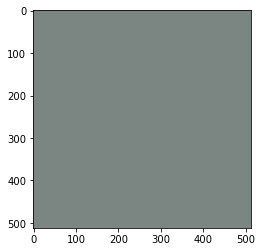

target


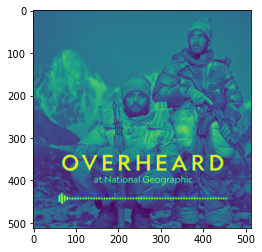

prediction


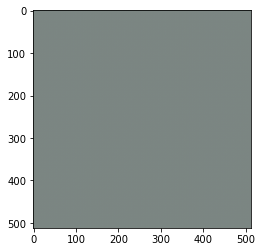

target


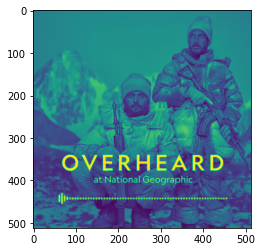

prediction


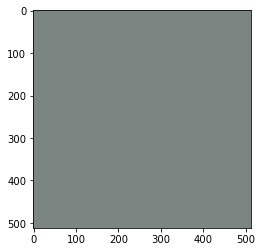

target


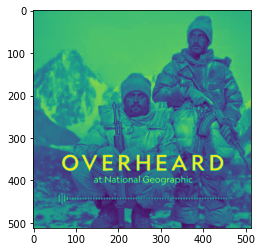

prediction


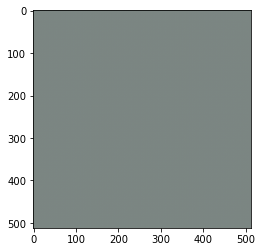

IndexError: index 3 is out of bounds for dimension 0 with size 3

In [16]:
# view testing data

resnet.eval()
bottleneck.eval()
decoder.eval()

root = "yt-dls/test/0/"
video_folders = np.random.permutation(os.listdir(root))
print(video_folders)
batched_input_1 = []
batched_input_2 = []
batched_targets = []
for video_folder in video_folders:
    # build up the batch
    #print(video_folder)
    num_frames = 30 # fit in memory batch * numframes
    frame_filenames = sorted(list(os.listdir(os.path.join(root, video_folder))))[0:num_frames]
    for i, frame_filename in enumerate(frame_filenames):
        #print(f"i, {i}")
        #print(f"frame_filename, {frame_filename}")
        frame_img = Image.open(os.path.join(root, video_folder, frame_filename))
        if i % 2 == 0:
            in_1 = data_transforms['train_in'](frame_img) # frame_i-1
            batched_input_1.append(in_1)
        else:
            in_2 = data_transforms['train_in'](frame_img)
            batched_input_2.append(in_2)
            target = data_transforms['train_target'](frame_img)
            batched_targets.append(target)
batched_input_1 = torch.stack(batched_input_1).to(device)
batched_input_2 = torch.stack(batched_input_2).to(device)
batched_targets = torch.stack(batched_targets).to(device)

embedding_1 = resnet(batched_input_1)
embedding_2 = resnet(batched_input_2)

cat_latent = torch.cat((embedding_1, embedding_2), dim=1)
moved_latent = torch.squeeze(cat_latent)

latent = bottleneck(moved_latent)

prediction = decoder(latent.unsqueeze(-1).unsqueeze(-1))
mse_loss = nn.MSELoss()
mse_loss_val = mse_loss(prediction, batched_targets)
loss = 1 * mse_loss_val

print(loss)

print(prediction.shape)
for i in range(len(prediction)):
    plt.imshow(transforms.functional.to_pil_image(prediction[i].cpu()))
    print("prediction")
    plt.show()
    plt.imshow(transforms.functional.to_pil_image(target[i].cpu()))
    print("target")
    plt.show()


In [9]:
prediction = last_prediction[1].cpu().detach()
target = batched_point[1][1]
input_target = data_transforms['train_in_no_normalize'](batched_point[1][1].permute(2,0,1))
print(prediction.shape)
#prediction_img = transforms.ToPILImage(prediction)
print(target.shape)

print("The original target frame")
plt.imshow(target)
plt.show()

transformed_target = data_transforms['train_target'](target.permute(2,0,1))
print("the target to optimize for")
plt.imshow(transformed_target.permute(1,2,0))
plt.show()
print("what the model saw")
plt.imshow(transforms.functional.to_pil_image(input_target))
plt.show()
print("what the model made")
plt.imshow(transforms.functional.to_pil_image(prediction))
plt.show()
print("bilinear baseline")
plt.imshow(transforms.functional.resize(transforms.functional.to_pil_image(input_target), 512))
#plt.plot(losses)

NameError: name 'last_prediction' is not defined